# Develop an ML Gaussian Process Regression model to learn Hardness Property of High entropy alloys

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


The dataset for this tutorial is taken from the following publication:

Wen, Cheng, et al. "Machine learning assisted design of high entropy alloys with desired property." Acta Materialia 170 (2019): 109-117 (https://doi.org/10.1016/j.actamat.2019.03.010).

This tutorial is similar to the previous linear regression tutorial. Here, instead of a linear model we will create a non-linear ML model (GPR) for high entropy alloy property prediction. We will achieve the following things:
1. Load high entropy alloy dataset
2. Use scikit-learn library to build GPR model
3. Cross-validation for hyper-parameter optimization
4. Training final GPR model
5. Uncertainty quantification
6. Feature selection using recursive feature elimination
7. Understanding the meaning of different hyper-parameters

#### Library imports

In [ ]:
import pandas as pd  # To play with data tables
import matplotlib.pyplot as plt  # To visualize data
import numpy as np
import time
import copy

In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.gaussian_process import GaussianProcessRegressor
from sklearn.gaussian_process.kernels import RBF
from sklearn.preprocessing import StandardScaler, MinMaxScaler

In [ ]:
from sklearn.model_selection import KFold

In [ ]:
from sklearn.model_selection import GridSearchCV
import itertools

In [ ]:
# First we will define function to make plots. This will make the code simpler.

def polt_parity(y_cv_test,y_pred_test, y_cv_train=None,y_pred_train=None, label=None, ylim=[50,900]):
    """
    Function to make parity plots.
    """

    # Plot Parity plot
    rmse_test = np.sqrt(mean_squared_error(y_cv_test,y_pred_test))
    r2_test = r2_score(y_cv_test,y_pred_test)

    if y_cv_train is None:
        fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4), sharey=True, sharex=True)
    else:
        fig, (ax1,ax2) = plt.subplots(nrows=1, ncols=2, figsize=(9,4), sharey=True, sharex=True)

    ax1.scatter(y_cv_test,y_pred_test)
    ax1.text(0.95, 0.26, label, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.text(0.95, 0.1, "R$^2$: %.2f"%r2_test, transform=ax1.transAxes, ha='right', fontsize=14)
    ax1.plot(ylim, ylim, '--k')
    ax1.set_xlabel('True y', fontsize=14)
    ax1.set_ylabel('Pred y', fontsize=14)
    ax1.set_xlim(ylim[0],ylim[1])
    ax1.set_ylim(ylim[0],ylim[1])

    if y_cv_train is not None:
        rmse_train = np.sqrt(mean_squared_error(y_cv_train,y_pred_train))
        r2_train = r2_score(y_cv_train,y_pred_train)

        ax2.scatter(y_cv_train,y_pred_train, c='m')
        ax2.text(0.95, 0.26, "Train", transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax2.transAxes, ha='right', fontsize=14)
        ax2.plot(ylim, ylim, '--k')

        ax2.set_xlabel('True y', fontsize=14)
        ax2.set_xlim(ylim[0],ylim[1])
        ax2.set_ylim(ylim[0],ylim[1])

    plt.tight_layout()
    plt.show()

    return None

### 1. Load data table

In [ ]:
!gdown 12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h

Downloading...
From: https://drive.google.com/uc?id=12m6iqvaAchdqAUCdvVxGQWSG6DREqF5h
To: /content/alloy-confp-train-data_v2.csv
100% 7.33k/7.33k [00:00<00:00, 7.52MB/s]


In [ ]:
data = pd.read_csv('/content/drive/MyDrive/ML-Project-Group10/alloy-full-train-DATASET.csv')
data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,...,Dk_D.G,Dk_D.x,Dk_fH,Dk_fpi,Dk_fdash,Dk_fA,Dk_A,Dk_F,Dk_fineq,Dk_fsqrt
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,-2.442590,1.931601,...,-2.421510,-1.090140,0.532049,-0.098240,5.981226,-2.030900,-2.584580,1.923412,1.884716,-2.762650
1,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.575486,-1.738410,...,0.115596,-0.317500,0.275243,-0.187710,-0.232830,0.286611,0.234105,-1.685660,0.107530,0.408426
2,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,1.093749,-2.322860,...,1.109189,1.220168,-1.499770,-0.307840,-0.238250,0.880942,0.470273,-2.394630,-1.530350,0.369335
3,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,-0.319490,0.221026,...,-0.258890,-0.411380,0.945172,0.392613,-0.210380,-0.576900,-0.229710,0.262366,0.509518,0.436561
4,141,655,0.149925,0.283358,0.283358,0.000000,0.283358,0.000000,0.241201,1.115530,...,-0.100290,-0.135110,-0.389730,-0.258430,-0.231460,0.404645,0.568023,1.031518,0.178788,0.430268
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,82,476,0.225000,0.225000,0.100000,0.000000,0.225000,0.225000,0.698325,-0.400130,...,0.053031,0.372619,-1.203860,-0.289580,-0.234330,0.850731,0.737584,-0.345980,-0.002130,0.414935
96,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.014367,1.557345,...,-0.596120,-0.342130,-0.151650,-0.247360,-0.229560,0.072990,0.386799,1.435387,0.581871,0.439698
97,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.320476,-0.019970,...,0.120649,0.231689,-0.224640,-0.221560,-0.226910,0.309614,0.421990,0.012930,0.092413,0.423563
98,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.353340,1.187070,...,0.202019,0.491712,-0.811460,-0.267970,-0.230110,0.593701,0.707933,1.078177,-0.148420,0.426522


### Notes about the data table

Above we see that data table has 5 types of columns:
1. smiles: These are string representation of polymers. We will use them to visualize polymers.
2. eib: We can ignore this for now.
3. bandgap_chain: This is the band gap values of polymers. Our target property (y).
4. bandgap_crystal: We can ignore this for now.
5. several columns starting with keyword "mfp_": These are molecular fingerprint columns that we will use for ML model. Our material fingeprints (X).

Notice we use small letter "y" and capital letter "X" to represent our target property and materials fingeprints respectively. Is there any particular reason for representing one with small and the other with capital alphabet?

#### Seperate X and y data

In [ ]:
Xcols = data.columns[data.columns.str.contains("C.")]
Xcols

Index(['C.al', 'C.co', 'C.cr', 'C.cu', 'C.fe', 'C.ni'], dtype='object')

In [ ]:
X = data[Xcols]
X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000
1,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222
2,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857
3,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818
4,0.149925,0.283358,0.283358,0.000000,0.283358,0.000000
...,...,...,...,...,...,...
95,0.225000,0.225000,0.100000,0.000000,0.225000,0.225000
96,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059
97,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667
98,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667


In [ ]:
y = data['HV']
y

0     139
1     545
2     701
3     207
4     655
     ... 
95    476
96    450
97    451
98    617
99    171
Name: HV, Length: 100, dtype: int64


---


### 2. Fit GPR model with five-fold cross-validation

In [ ]:
noise_estimated = 30
kernel = 1 * RBF(length_scale=1.0, length_scale_bounds=(1e-4, 1e2))
kernel.k1.constant_value_bounds = (10**-2, 10**7)

In [ ]:
gaussian_process = GaussianProcessRegressor(
    kernel=kernel, alpha=noise_estimated**2, n_restarts_optimizer=9
)

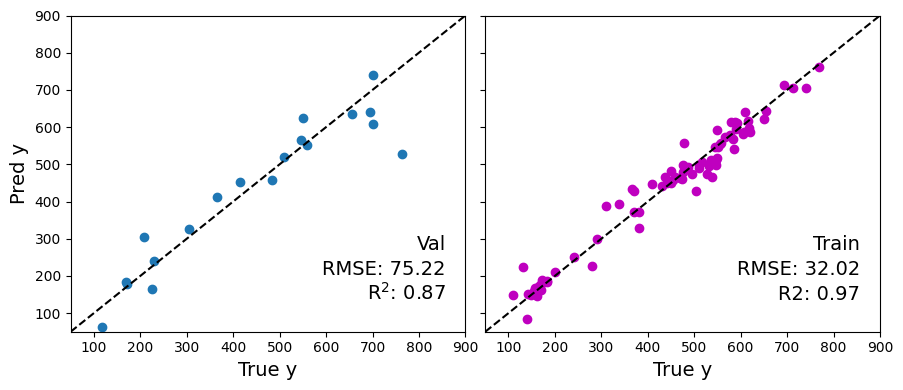

Kernel parameters: 311**2 * RBF(length_scale=0.231)
log marginal likelihood: -488.201
Root mean squared error: 75.22
Coefficient of determination: 0.87


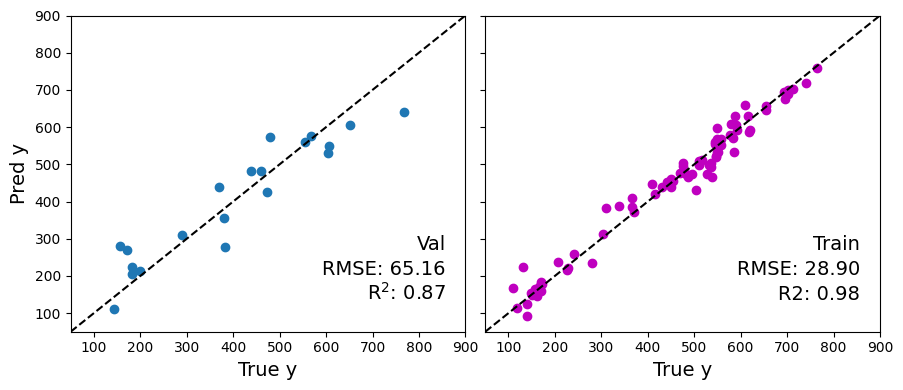

Kernel parameters: 323**2 * RBF(length_scale=0.231)
log marginal likelihood: -484.887
Root mean squared error: 65.16
Coefficient of determination: 0.87


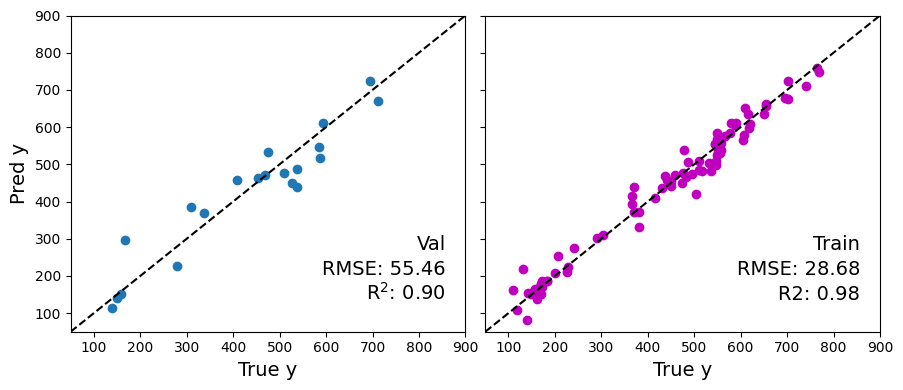

Kernel parameters: 322**2 * RBF(length_scale=0.233)
log marginal likelihood: -484.576
Root mean squared error: 55.46
Coefficient of determination: 0.90


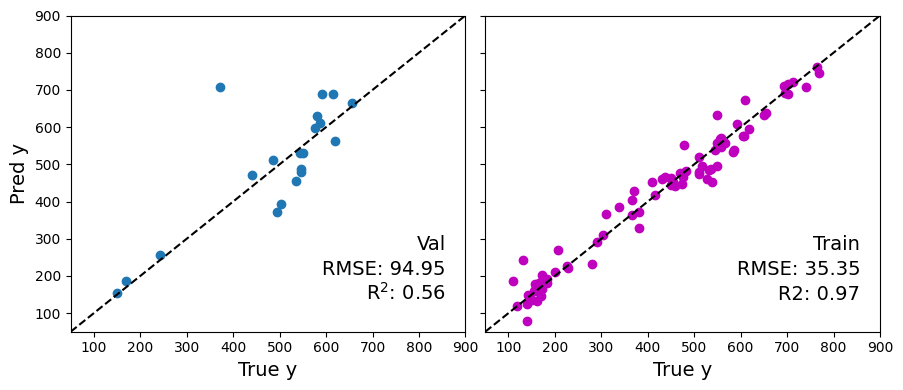

Kernel parameters: 355**2 * RBF(length_scale=0.301)
log marginal likelihood: -485.492
Root mean squared error: 94.95
Coefficient of determination: 0.56


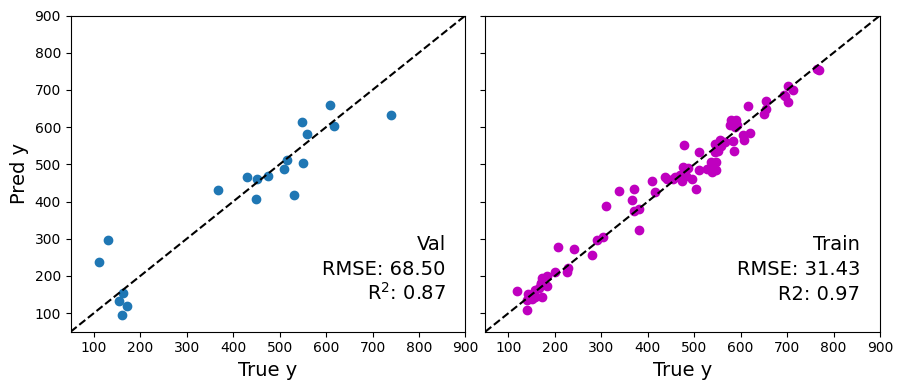

Kernel parameters: 342**2 * RBF(length_scale=0.295)
log marginal likelihood: -473.734
Root mean squared error: 68.50
Coefficient of determination: 0.87


In [ ]:
kf = KFold(n_splits=5)

errors = []
kernels = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Kernel parameters: %s"%(model.kernel_))
    print("log marginal likelihood: %.3f" %model.log_marginal_likelihood_value_)
    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors.append(error)
    kernels.append(model.kernel_)

In [ ]:
errors_gpr_cv = pd.DataFrame(errors)
errors_gpr_cv

,kfold,rmse_train,r2_train,rmse_val,r2_val
0,1,32.018692,0.967274,75.220814,0.874426
1,2,28.902778,0.975343,65.157975,0.874492
2,3,28.683240,0.976406,55.464468,0.900583
3,4,35.352892,0.965738,94.948270,0.556817
4,5,31.429150,0.970584,68.495017,0.868180


In [ ]:
errors_gpr_cv[['rmse_val','r2_val']].mean()

rmse_val    71.857309
r2_val       0.814899
dtype: float64

#### Comparing against Best Error from Polynomial Regression (from Previous notebook).
1. rmse_test: 77.69
2. r2_test: 0.81

### Question
1. Compare the GPR and linear regression model in terms of accuracy? Is such behavior always expected?
2. What can we do to improve the performance of GPR model?

Answer 1)

Ans

#### Using the median kernel parameters obtained from different k-folds

In [ ]:
kernels

[311**2 * RBF(length_scale=0.231),
 323**2 * RBF(length_scale=0.231),
 322**2 * RBF(length_scale=0.233),
 355**2 * RBF(length_scale=0.301),
 342**2 * RBF(length_scale=0.295)]

In [ ]:
sigma_cs = []
sigma_ls = []

for k in kernels:
    sigma_cs.append(k.k1.constant_value)
    sigma_ls.append(k.k2.length_scale)
k_best = np.median(sigma_cs) * RBF(length_scale=np.median(sigma_ls), length_scale_bounds=(1e-4, 1e2))
k_best.k1.constant_value_bounds = (10**-2, 10**7)

In [ ]:
np.median(sigma_cs), np.median(sigma_ls)

(104314.81169732394, 0.23300698605979767)

In [ ]:
k_best

323**2 * RBF(length_scale=0.233)

***

### 3. Optimization of alpha param

In [ ]:
alpha_values = np.array([26, 30, 31, 32, 33, 34, 35, 36, 39, 40, 42, 45])**2
hyper_params = {'alpha':alpha_values}

In [ ]:
kernel = k_best.k1.constant_value * RBF(length_scale=k_best.k2.length_scale, length_scale_bounds=(1e-4, 1e2))
kernel.k1.constant_value_bounds = (10**-2, 10**7)

In [ ]:
gaussian_process = GaussianProcessRegressor(kernel=kernel, n_restarts_optimizer=3)

In [ ]:
clf2 = GridSearchCV(gaussian_process, hyper_params, cv=5,
                   scoring='neg_mean_squared_error', verbose=0)

In [ ]:
clf2.fit(X,y)

GridSearchCV(cv=5,
             estimator=GaussianProcessRegressor(kernel=323**2 * RBF(length_scale=0.233),
                                                n_restarts_optimizer=3),
             param_grid={'alpha': array([ 676,  900,  961, 1024, 1089, 1156, 1225, 1296, 1521, 1600, 1764,
       2025])},
             scoring='neg_mean_squared_error')

In [ ]:
rmse_list2 = np.sqrt(clf2.cv_results_['mean_test_score']*-1)
min_idx = np.argmin(rmse_list2)

In [ ]:
alpha_opt = alpha_values[min_idx]

print()
print("Best CV error: %.4f" %rmse_list2[min_idx])
print("Optimal alpha: %.2f" %np.sqrt(alpha_opt))


Best CV error: 73.0572
Optimal alpha: 30.00


Text(0, 0.5, 'RMSE')

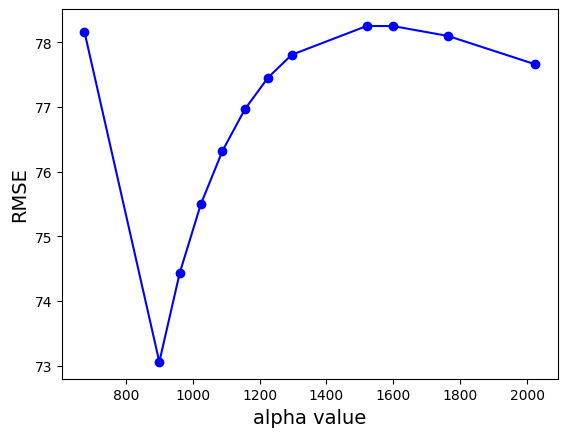

In [ ]:
plt.plot(alpha_values, rmse_list2, '-bo')
#plt.yscale('log')
#plt.xscale('log')
plt.xlabel('alpha value', fontsize=14)
plt.ylabel('RMSE', fontsize=14)

#### Re-running CV with optimal alpha

In [ ]:
gaussian_process = GaussianProcessRegressor(kernel=k_best, alpha=alpha_opt)

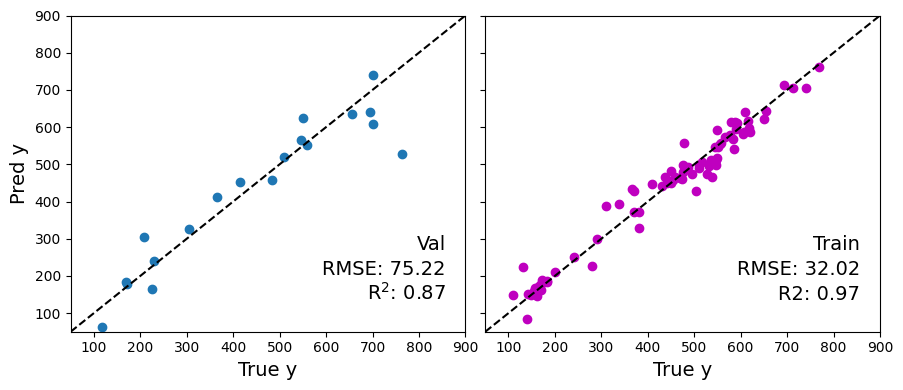

Kernel parameters: 311**2 * RBF(length_scale=0.231)
log marginal likelihood: -488.201
Root mean squared error: 75.22
Coefficient of determination: 0.87


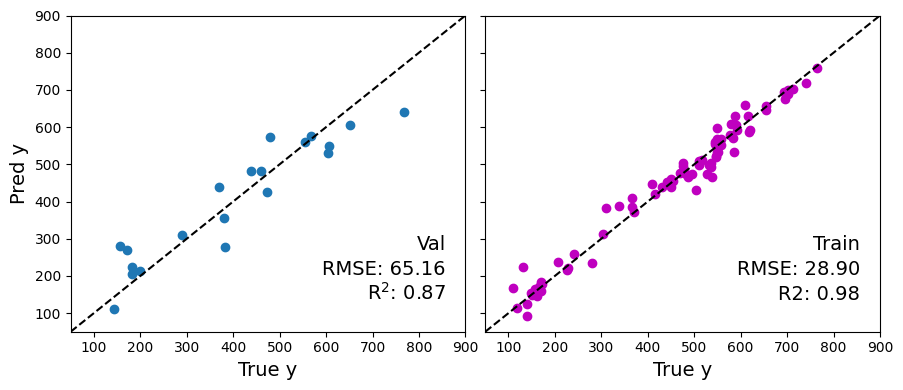

Kernel parameters: 323**2 * RBF(length_scale=0.231)
log marginal likelihood: -484.887
Root mean squared error: 65.16
Coefficient of determination: 0.87


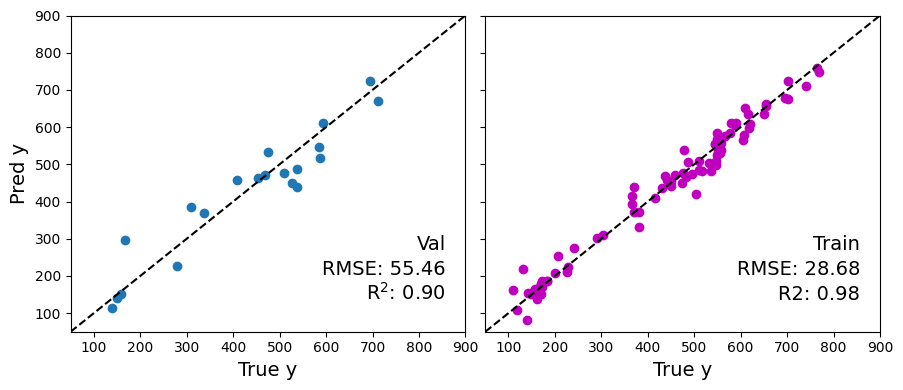

Kernel parameters: 322**2 * RBF(length_scale=0.233)
log marginal likelihood: -484.576
Root mean squared error: 55.46
Coefficient of determination: 0.90


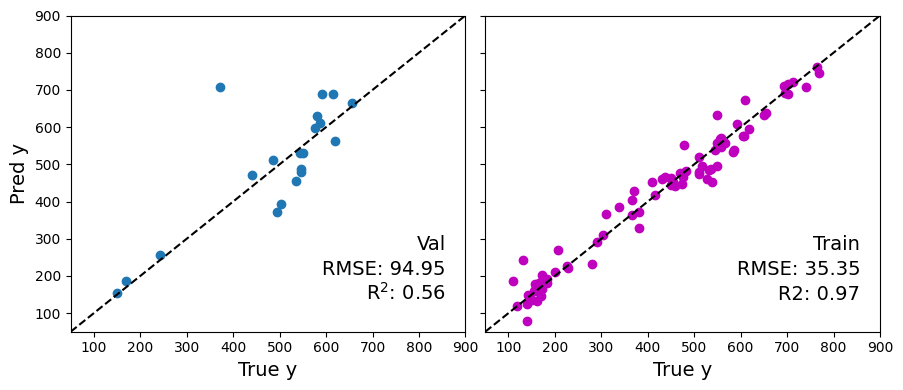

Kernel parameters: 355**2 * RBF(length_scale=0.301)
log marginal likelihood: -485.492
Root mean squared error: 94.95
Coefficient of determination: 0.56


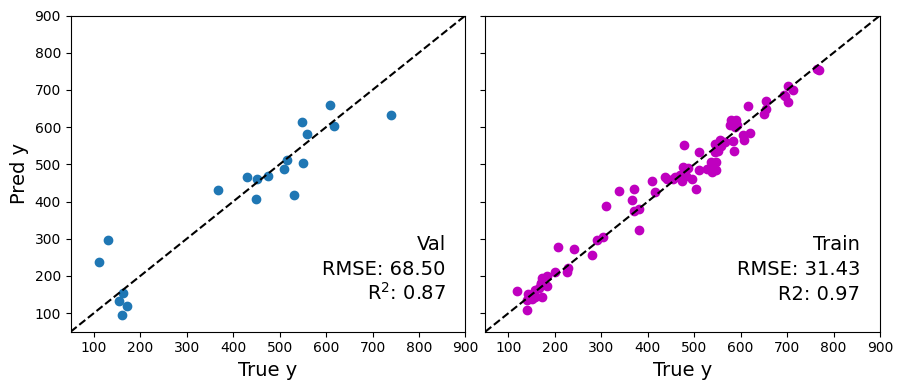

Kernel parameters: 342**2 * RBF(length_scale=0.295)
log marginal likelihood: -473.734
Root mean squared error: 68.50
Coefficient of determination: 0.87


In [ ]:
kf = KFold(n_splits=5)

errors = []
kernels = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    mse_val = mean_squared_error(y_cv_val, y_pred_val)
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Kernel parameters: %s"%(model.kernel_))
    print("log marginal likelihood: %.3f" %model.log_marginal_likelihood_value_)
    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'mse_val': mse_val
            }

    errors.append(error)
    kernels.append(model.kernel_)

In [ ]:
errors_gpr_cv_opt_alpha = pd.DataFrame(errors)
errors_gpr_cv_opt_alpha.mean()

kfold            3.000000
rmse_train      31.277339
r2_train         0.971069
rmse_val        71.857324
r2_val           0.814899
mse_val       5337.358371
dtype: float64

In [ ]:
np.sqrt(errors_gpr_cv_opt_alpha['mse_val'].mean())

73.05722668389942

In [ ]:
kernels

[311**2 * RBF(length_scale=0.231),
 323**2 * RBF(length_scale=0.231),
 322**2 * RBF(length_scale=0.233),
 355**2 * RBF(length_scale=0.301),
 342**2 * RBF(length_scale=0.295)]

In [ ]:
# Again finding the best kernel parameters for final model training
sigma_cs = []
sigma_ls = []

print("Previous k_best: ", k_best)

for k in kernels:
    sigma_cs.append(k.k1.constant_value)
    sigma_ls.append(k.k2.length_scale)
k_opt = np.median(sigma_cs) * RBF(length_scale=np.median(sigma_ls), length_scale_bounds=(1e-4, 1e2))
k_opt.k1.constant_value_bounds = (10**-2, 10**7)

print("New k_best: ", k_opt)

Previous k_best:  323**2 * RBF(length_scale=0.233)
New k_best:  323**2 * RBF(length_scale=0.233)


### 4. Train the final GPR model

In [ ]:
# IMP NOTE: The optimizer is set to None

gaussian_process = GaussianProcessRegressor(kernel=k_opt, alpha=alpha_opt, optimizer=None)

model = gaussian_process.fit(X,y)
print()
print(model.kernel_, model.kernel)


323**2 * RBF(length_scale=0.233) 323**2 * RBF(length_scale=0.233)


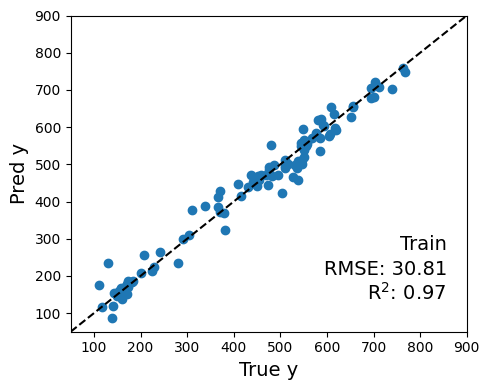

Kernel parameters: 323**2 * RBF(length_scale=0.233)
Root mean squared error: 30.81
Coefficient of determination: 0.97


In [ ]:
y_pred = model.predict(X)

# Computing errors
rmse_train = np.sqrt(mean_squared_error(y, y_pred))
r2_train = r2_score(y, y_pred)

# Plot Parity plot
polt_parity(y,y_pred,label="Train")

print("Kernel parameters: %s"%(model.kernel_))
print("Root mean squared error: %.2f" % rmse_train)
print("Coefficient of determination: %.2f" % r2_train)


***

### 5. Uncertainty Prediction

In [ ]:
y_pred, y_std = model.predict(X, return_std=True)

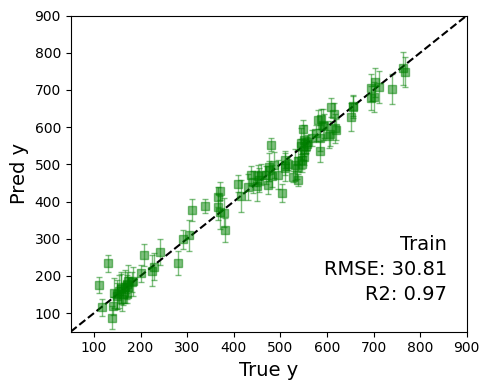

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))

ax1.errorbar(y, y_pred, y_std*1.5, fmt='s', c='g', alpha=0.5, elinewidth=1, capsize=2)
ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('True y', fontsize=14)
ax1.set_ylabel('Pred y', fontsize=14)

ax1.text(0.95, 0.26, "Train", transform=ax1.transAxes, ha='right', fontsize=14)
ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)

ax1.set_xlim([50,900])
ax1.set_ylim([50,900])

plt.tight_layout()
plt.show()

### Prediction for Test data

In [ ]:
!gdown 1lrfEnHh9pPItZQNO6cms9gp5PmhIB5De

Downloading...
From: https://drive.google.com/uc?id=1lrfEnHh9pPItZQNO6cms9gp5PmhIB5De
To: /content/alloy-confp-test-data_v2.csv
100% 2.15k/2.15k [00:00<00:00, 3.79MB/s]


In [ ]:
data1 = pd.read_csv('/content/drive/MyDrive/ML-Project-Group10/alloy-test-DATASET.csv')
Xcols = data.columns[data.columns.str.contains("C.")]
test_X = data1[Xcols]
test_X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni
0,0.090909,0.227273,0.227273,0.000000,0.227273,0.227273
1,0.000000,0.225000,0.100000,0.225000,0.225000,0.225000
2,0.142857,0.285714,0.000000,0.000000,0.285714,0.285714
3,0.090909,0.000000,0.181818,0.181818,0.181818,0.363636
4,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667
5,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846
6,0.137931,0.000000,0.172414,0.172414,0.172414,0.344828
7,0.166667,0.166667,0.166667,0.083333,0.166667,0.250000
8,0.166667,0.000000,0.166667,0.166667,0.166667,0.333333
9,0.181818,0.181818,0.181818,0.181818,0.181818,0.090909


In [ ]:
y = data1['HV']

In [ ]:
test_y_pred, test_y_std = model.predict(test_X, return_std=True)

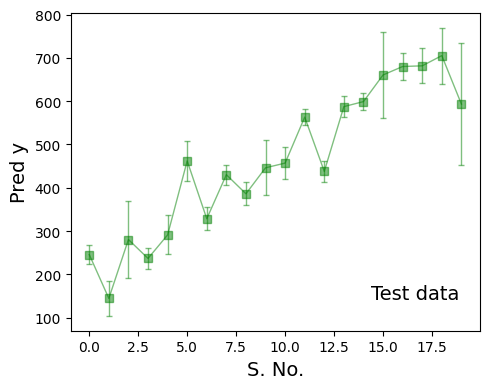

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))


ax1.errorbar(np.arange(len(test_y_pred)), test_y_pred, test_y_std*1.5, fmt='-s', c='g', alpha=0.5, elinewidth=1, capsize=2, lw=1)
#ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('S. No.', fontsize=14)
ax1.set_ylabel('Pred y', fontsize=14)

ax1.text(0.95, 0.1, "Test data", transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)

#ax1.set_xlim([50,900])
#ax1.set_ylim([50,900])

plt.tight_layout()
plt.show()

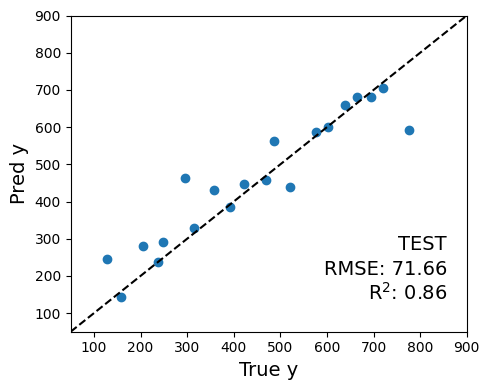

Kernel parameters: 323**2 * RBF(length_scale=0.233)
Root mean squared error: 71.66
Coefficient of determination: 0.86


In [ ]:
rmse_test = np.sqrt(mean_squared_error(y, test_y_pred))
r2_test = r2_score(y, test_y_pred)

# Plot Parity plot
polt_parity(y,test_y_pred,label="TEST")

print("Kernel parameters: %s"%(model.kernel_))
print("Root mean squared error: %.2f" % rmse_test)
print("Coefficient of determination: %.2f" % r2_test)


### Question
3. Why error bars from some data points are smaller as compared to others?

### Better models using Better Physical Features

### Question
4. Why inclusion of physical features of alloys is expected to improve the performance of the ML model?

In [ ]:
!gdown 1eDfSMMDuOVSgsZPNwYJ1U5hIEHy-P4T6

Downloading...
From: https://drive.google.com/uc?id=1eDfSMMDuOVSgsZPNwYJ1U5hIEHy-P4T6
To: /content/alloy-full-train-data_v2.csv
100% 28.8k/28.8k [00:00<00:00, 27.8MB/s]


In [ ]:
full_train_data = pd.read_csv('/content/drive/MyDrive/ML-Project-Group10/alloy-full-train-DATASET new 1.csv')
full_train_data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,...,sqrt_C.cu,exp_C.fe,exp_neg_C.fe,cubed_C.fe,squared_C.fe,sqrt_C.fe,exp_C.ni.1,exp_neg_C.ni,cubed_C.ni,squared_C.ni
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,-2.442590,1.931601,...,0.000000,1.284025,0.778801,0.015625,0.062500,0.500000,1.284025,0.778801,0.015625,0.062500
1,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.575486,-1.738410,...,0.471405,1.248849,0.800737,0.010974,0.049383,0.471405,1.248849,0.800737,0.010974,0.049383
2,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,1.093749,-2.322860,...,0.267261,1.074041,0.931063,0.000364,0.005102,0.267261,1.153565,0.866878,0.002915,0.020408
3,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,-0.319490,0.221026,...,0.426401,1.199396,0.833753,0.006011,0.033058,0.426401,1.199396,0.833753,0.006011,0.033058
4,141,655,0.149925,0.283358,0.283358,0.000000,0.283358,0.000000,0.241201,1.115530,...,0.000000,1.327581,0.753250,0.022751,0.080292,0.532314,1.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,82,476,0.225000,0.225000,0.100000,0.000000,0.225000,0.225000,0.698325,-0.400130,...,0.000000,1.252323,0.798516,0.011391,0.050625,0.474342,1.252323,0.798516,0.011391,0.050625
96,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.014367,1.557345,...,0.000000,1.554535,0.643279,0.085869,0.194637,0.664211,1.158422,0.863243,0.003180,0.021626
97,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.320476,-0.019970,...,0.288675,1.181360,0.846482,0.004630,0.027778,0.408248,1.181360,0.846482,0.004630,0.027778
98,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.353340,1.187070,...,0.000000,1.181360,0.846482,0.004630,0.027778,0.408248,1.181360,0.846482,0.004630,0.027778


In [ ]:
Xcols = full_train_data.columns[(full_train_data.columns.str.contains("C.")) | (full_train_data.columns.str.contains("Dk_"))]
Xcols

Index(['C.al', 'C.co', 'C.cr', 'C.cu', 'C.fe', 'C.ni', 'Dk_fr', 'Dk_G',
       'Dk_fG', 'Dk_fx', 'Dk_e.a', 'Dk_vec', 'Dk_Ec', 'Dk_w', 'Dk_fS',
       'Dk_D.r', 'Dk_D.G', 'Dk_D.x', 'Dk_fH', 'Dk_fpi', 'Dk_fdash', 'Dk_fA',
       'Dk_A', 'Dk_F', 'Dk_fineq', 'Dk_fsqrt', 'sqrt_C.co', 'exp_C.ni',
       'sqrt_Dk_D.x', 'sqrt_C.ni', 'sqrt_Dk_fineq', 'exp_Dk_fH',
       'exp_neg_Dk_fH', 'exp_neg_Dk_fsqrt', 'cubed_Dk_fsqrt',
       'squared_Dk_fsqrt', 'sqrt_Dk_fsqrt', 'sqrt_C.cr', 'exp_C.cu',
       'exp_neg_C.cu', 'cubed_C.cu', 'squared_C.cu', 'sqrt_C.cu', 'exp_C.fe',
       'exp_neg_C.fe', 'cubed_C.fe', 'squared_C.fe', 'sqrt_C.fe', 'exp_C.ni.1',
       'exp_neg_C.ni', 'cubed_C.ni', 'squared_C.ni'],
      dtype='object')

In [ ]:
X = full_train_data[Xcols]
X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,Dk_fG,Dk_fx,...,sqrt_C.cu,exp_C.fe,exp_neg_C.fe,cubed_C.fe,squared_C.fe,sqrt_C.fe,exp_C.ni.1,exp_neg_C.ni,cubed_C.ni,squared_C.ni
0,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,-2.442590,1.931601,-2.141950,-1.215900,...,0.000000,1.284025,0.778801,0.015625,0.062500,0.500000,1.284025,0.778801,0.015625,0.062500
1,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.575486,-1.738410,-0.083060,-0.051180,...,0.471405,1.248849,0.800737,0.010974,0.049383,0.471405,1.248849,0.800737,0.010974,0.049383
2,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,1.093749,-2.322860,1.670192,1.446628,...,0.267261,1.074041,0.931063,0.000364,0.005102,0.267261,1.153565,0.866878,0.002915,0.020408
3,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,-0.319490,0.221026,-0.341910,-0.435350,...,0.426401,1.199396,0.833753,0.006011,0.033058,0.426401,1.199396,0.833753,0.006011,0.033058
4,0.149925,0.283358,0.283358,0.000000,0.283358,0.000000,0.241201,1.115530,-0.289360,-0.320160,...,0.000000,1.327581,0.753250,0.022751,0.080292,0.532314,1.000000,1.000000,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.225000,0.225000,0.100000,0.000000,0.225000,0.225000,0.698325,-0.400130,0.029721,0.302827,...,0.000000,1.252323,0.798516,0.011391,0.050625,0.474342,1.252323,0.798516,0.011391,0.050625
96,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.014367,1.557345,-0.705380,-0.519140,...,0.000000,1.554535,0.643279,0.085869,0.194637,0.664211,1.158422,0.863243,0.003180,0.021626
97,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.320476,-0.019970,-0.000690,0.152051,...,0.288675,1.181360,0.846482,0.004630,0.027778,0.408248,1.181360,0.846482,0.004630,0.027778
98,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.353340,1.187070,-0.050140,0.355758,...,0.000000,1.181360,0.846482,0.004630,0.027778,0.408248,1.181360,0.846482,0.004630,0.027778


In [ ]:
y = full_train_data['HV']
y

0     139
1     545
2     701
3     207
4     655
     ... 
95    476
96    450
97    451
98    617
99    171
Name: HV, Length: 100, dtype: int64

In [ ]:
new_data = full_train_data.copy()

In [ ]:
def make_new_feature(full_train_data, cols, powers, new_col_name):
    full_train_data[new_col_name] = 1
    for power, col  in zip(powers, cols):
        full_train_data[new_col_name] = np.cos(full_train_data[new_col_name]) * np.sin((full_train_data[Xcols[col]]) ** power)

    return full_train_data

def make_new_feature1(full_train_data, cols, powers, new_col_name):
    full_train_data[new_col_name] = 1
    for power, col  in zip(powers, cols):
        full_train_data[new_col_name] = full_train_data[new_col_name] * np.sin((full_train_data[Xcols[col]]) ** power)

    return full_train_data


In [ ]:

cols = [0,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.1')

cols = [1,3]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.2')

cols = [0,0]
powers = [1,2]
new_data = make_new_feature(new_data, cols, powers, 'C.3')

cols = [0,0,0]
powers = [1,1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.4')

cols = [4,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.5')

cols = [3,1]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.6')

cols = [9,8]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.7')

cols = [5,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.8')

cols = [0,16]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.9')

cols = [0,16]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.10')

cols = [4,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.11')

cols = [0,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'D.1')

cols = [0,11]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'D.2')

cols = [9,14]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'D.3')

cols = [11,21]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'D.4')


In [ ]:
new_data

,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,...,C.6,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4
0,7,139,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,-2.442590,1.931601,...,0.247404,-0.735600,0.000000,-0.659447,-0.659447,0.000000,0.000000,0.686125,-0.821190,-0.835139
1,108,545,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.575486,-1.738410,...,0.110097,-0.082933,0.218837,0.114522,0.114522,0.218837,0.218837,0.538307,0.209229,0.270661
2,146,701,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,1.093749,-2.322860,...,0.212491,0.855442,0.414343,0.872863,0.872863,0.415263,0.405140,-0.972153,-0.098731,0.662067
3,37,207,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,-0.319490,0.221026,...,0.179956,-0.326621,0.090351,-0.255700,-0.255700,0.090351,0.090675,0.706767,0.974089,-0.506048
4,141,655,0.149925,0.283358,0.283358,0.000000,0.283358,0.000000,0.241201,1.115530,...,0.279582,-0.281224,0.149364,-0.099796,-0.099796,0.147663,0.148878,-0.802448,-0.977057,0.357031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,82,476,0.225000,0.225000,0.100000,0.000000,0.225000,0.225000,0.698325,-0.400130,...,0.223106,0.029332,0.221487,0.052621,0.052621,0.221487,0.221487,-0.414504,0.147070,0.732714
96,72,450,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.014367,1.557345,...,0.000000,-0.625169,0.117008,-0.560307,-0.560307,0.114266,0.117140,-0.670822,-0.786671,0.068169
97,73,451,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.320476,-0.019970,...,0.247154,-0.000688,0.165230,0.119873,0.119873,0.165230,0.165230,-0.013067,0.987899,0.304683
98,135,617,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.353340,1.187070,...,0.165896,-0.049234,0.165230,0.199842,0.199842,0.165230,0.165230,-0.775386,0.060009,0.510668


In [ ]:
Xcols = new_data.columns[new_data.columns.str.contains("C.") | new_data.columns.str.contains("Dk_.") | new_data.columns.str.contains("C.")| new_data.columns.str.contains("D.")]
X = new_data[Xcols]
X   # 67 columns ###########################################################

,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,Dk_fG,Dk_fx,...,C.6,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4
0,0.000000,0.250000,0.250000,0.000000,0.250000,0.250000,-2.442590,1.931601,-2.141950,-1.215900,...,0.247404,-0.735600,0.000000,-0.659447,-0.659447,0.000000,0.000000,0.686125,-0.821190,-0.835139
1,0.222222,0.111111,0.000000,0.222222,0.222222,0.222222,0.575486,-1.738410,-0.083060,-0.051180,...,0.110097,-0.082933,0.218837,0.114522,0.114522,0.218837,0.218837,0.538307,0.209229,0.270661
2,0.428571,0.214286,0.071429,0.071429,0.071429,0.142857,1.093749,-2.322860,1.670192,1.446628,...,0.212491,0.855442,0.414343,0.872863,0.872863,0.415263,0.405140,-0.972153,-0.098731,0.662067
3,0.090909,0.181818,0.181818,0.181818,0.181818,0.181818,-0.319490,0.221026,-0.341910,-0.435350,...,0.179956,-0.326621,0.090351,-0.255700,-0.255700,0.090351,0.090675,0.706767,0.974089,-0.506048
4,0.149925,0.283358,0.283358,0.000000,0.283358,0.000000,0.241201,1.115530,-0.289360,-0.320160,...,0.279582,-0.281224,0.149364,-0.099796,-0.099796,0.147663,0.148878,-0.802448,-0.977057,0.357031
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.225000,0.225000,0.100000,0.000000,0.225000,0.225000,0.698325,-0.400130,0.029721,0.302827,...,0.223106,0.029332,0.221487,0.052621,0.052621,0.221487,0.221487,-0.414504,0.147070,0.732714
96,0.117647,0.000000,0.294118,0.000000,0.441176,0.147059,0.014367,1.557345,-0.705380,-0.519140,...,0.000000,-0.625169,0.117008,-0.560307,-0.560307,0.114266,0.117140,-0.670822,-0.786671,0.068169
97,0.166667,0.250000,0.166667,0.083333,0.166667,0.166667,0.320476,-0.019970,-0.000690,0.152051,...,0.247154,-0.000688,0.165230,0.119873,0.119873,0.165230,0.165230,-0.013067,0.987899,0.304683
98,0.166667,0.166667,0.333333,0.000000,0.166667,0.166667,0.353340,1.187070,-0.050140,0.355758,...,0.165896,-0.049234,0.165230,0.199842,0.199842,0.165230,0.165230,-0.775386,0.060009,0.510668


In [ ]:
#kernel = 300**2 * RBF(length_scale=0.2, length_scale_bounds=(1e-4, 1e2))
#kernel.k1.constant_value_bounds = (10**-2, 10**7)
noise_estimated = 35

gaussian_process = GaussianProcessRegressor(
    kernel=k_opt, alpha=noise_estimated**2, n_restarts_optimizer=3
)

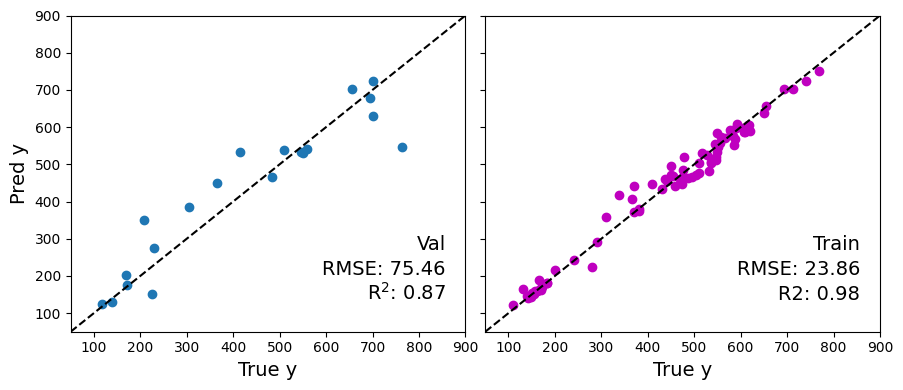

Kernel parameters: 321**2 * RBF(length_scale=4.09)
Root mean squared error: 75.46
Coefficient of determination: 0.87


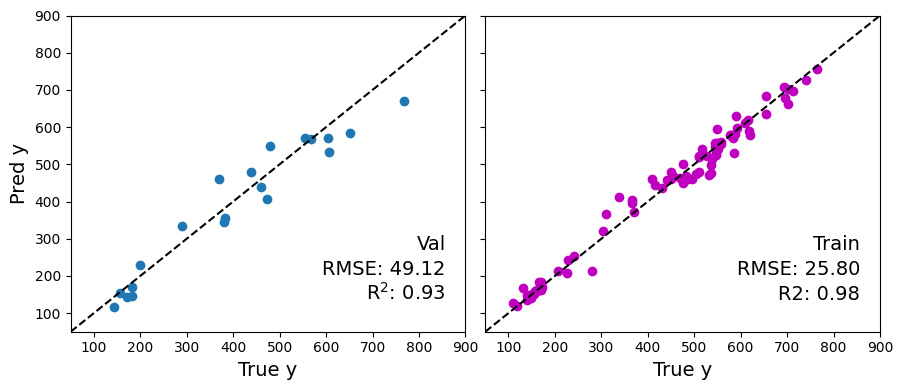

Kernel parameters: 311**2 * RBF(length_scale=4.18)
Root mean squared error: 49.12
Coefficient of determination: 0.93


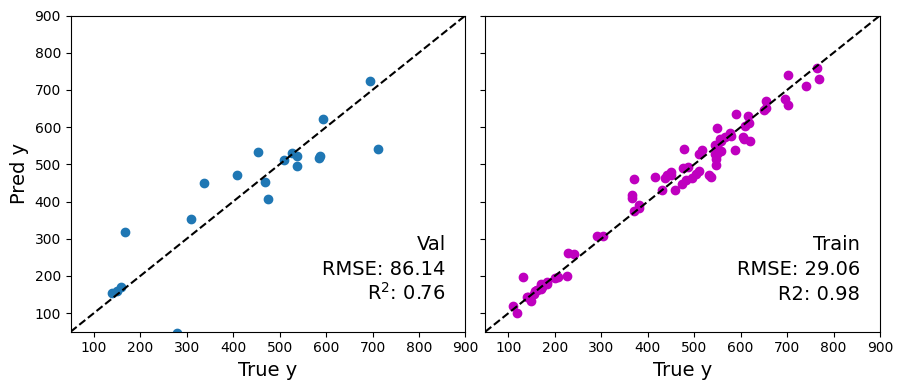

Kernel parameters: 329**2 * RBF(length_scale=5.82)
Root mean squared error: 86.14
Coefficient of determination: 0.76


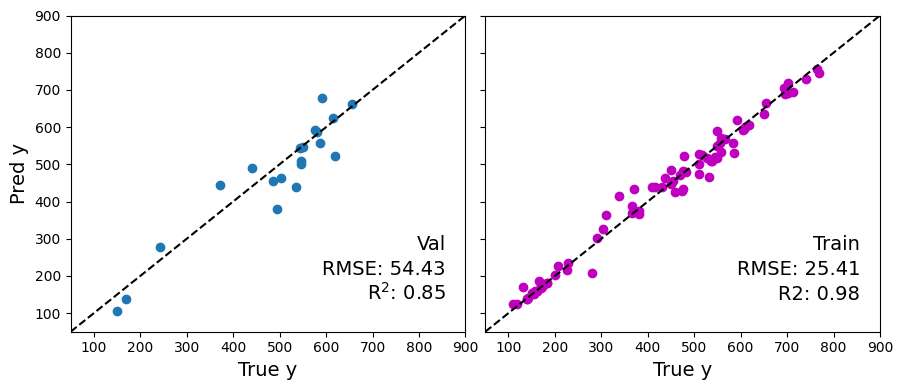

Kernel parameters: 329**2 * RBF(length_scale=4.47)
Root mean squared error: 54.43
Coefficient of determination: 0.85


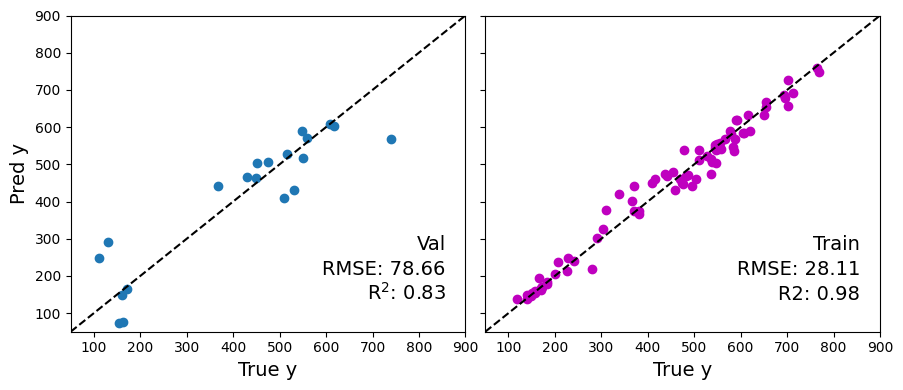

Kernel parameters: 380**2 * RBF(length_scale=5.51)
Root mean squared error: 78.66
Coefficient of determination: 0.83


In [ ]:
kf = KFold(n_splits=5)

errors = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Kernel parameters: %s"%(model.kernel_))
    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors.append(error)

In [ ]:
errors_gpr_cv_phFeatures = pd.DataFrame(errors)
errors_gpr_cv_phFeatures

,kfold,rmse_train,r2_train,rmse_val,r2_val
0,1,23.859891,0.981827,75.455772,0.873640
1,2,25.795855,0.980359,49.116901,0.928682
2,3,29.057700,0.975786,86.140307,0.760204
3,4,25.410666,0.982299,54.427085,0.854374
4,5,28.114527,0.976462,78.662659,0.826140


In [ ]:
errors_gpr_cv_phFeatures[['rmse_val','r2_val']].mean()

rmse_val    68.760545
r2_val       0.848608
dtype: float64

### Question
5. Inclusion of physical features doesn't seem to improve the ML model performance. Are we missing something during the model training?

### Feature normalization; Retrain model

In [ ]:
scaler = StandardScaler()

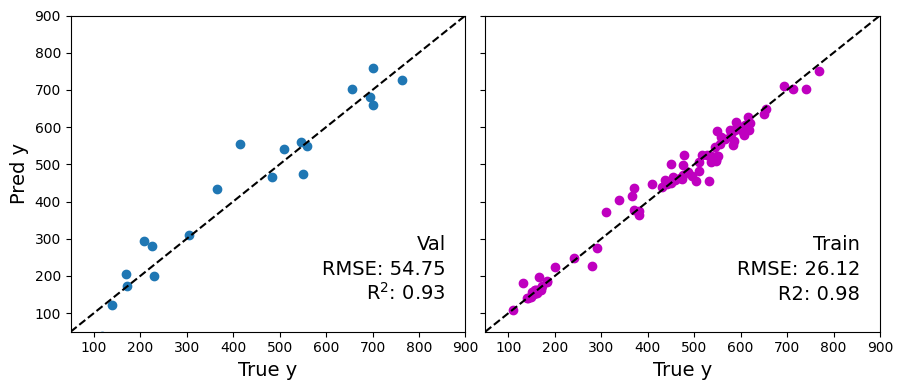

Kernel parameters: 311**2 * RBF(length_scale=9.34)
Root mean squared error: 54.75
Coefficient of determination: 0.93


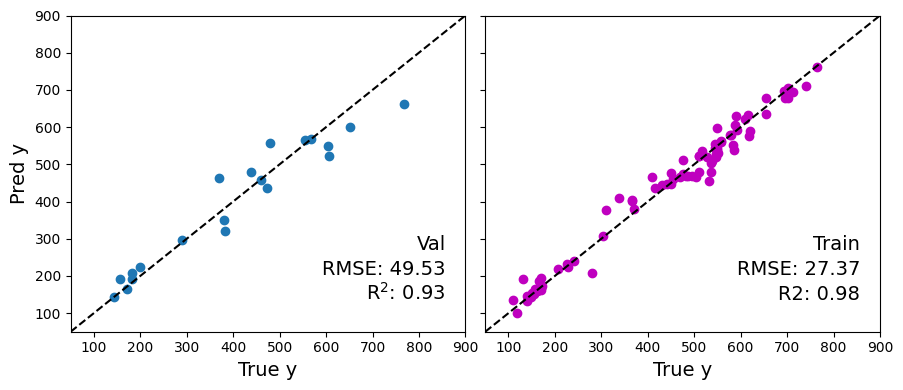

Kernel parameters: 285**2 * RBF(length_scale=9.03)
Root mean squared error: 49.53
Coefficient of determination: 0.93


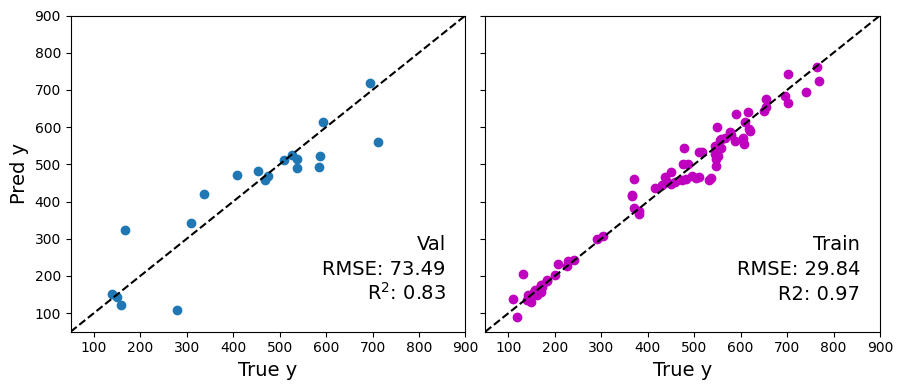

Kernel parameters: 303**2 * RBF(length_scale=11)
Root mean squared error: 73.49
Coefficient of determination: 0.83


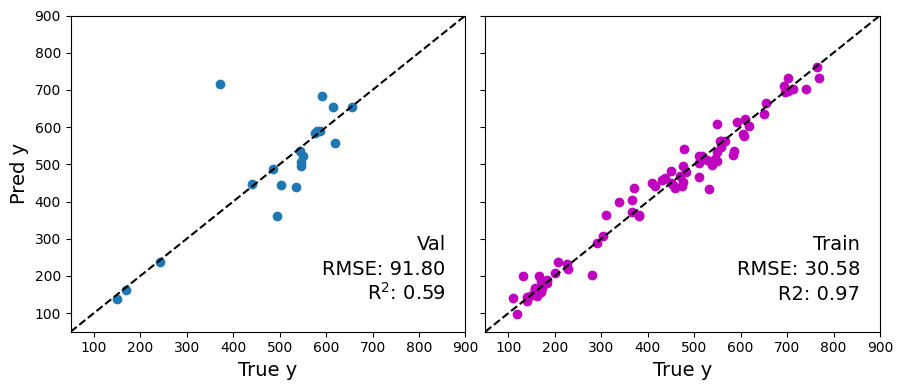

Kernel parameters: 340**2 * RBF(length_scale=11.4)
Root mean squared error: 91.80
Coefficient of determination: 0.59


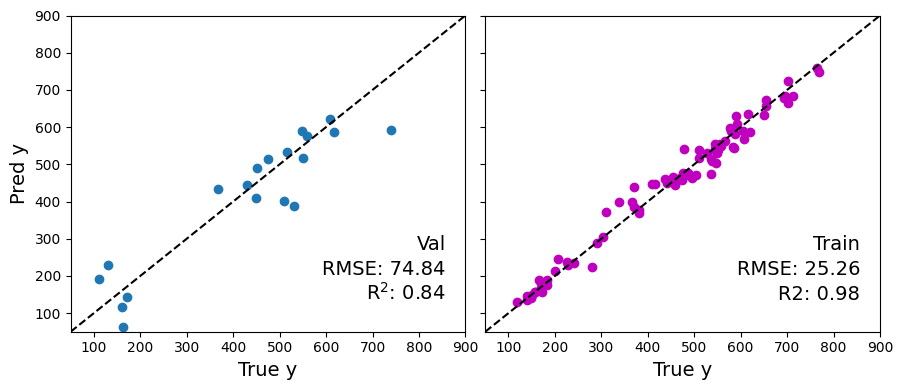

Kernel parameters: 359**2 * RBF(length_scale=11.4)
Root mean squared error: 74.84
Coefficient of determination: 0.84


In [ ]:
kf = KFold(n_splits=5)

errors = []

for idx, (train, val) in enumerate(kf.split(X)):
    _X_cv_train = X.values[train]
    _X_cv_val = X.values[val]

    X_cv_train = scaler.fit_transform(_X_cv_train)
    X_cv_val = scaler.transform(_X_cv_val)

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]

    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    print("Kernel parameters: %s"%(model.kernel_))
    print("Root mean squared error: %.2f" % rmse_val)
    print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val
            }

    errors.append(error)

In [ ]:
errors_gpr_cv_fpnorm = pd.DataFrame(errors)
errors_gpr_cv_fpnorm

,kfold,rmse_train,r2_train,rmse_val,r2_val
0,1,26.115652,0.978228,54.745378,0.933485
1,2,27.367075,0.977893,49.526530,0.927487
2,3,29.836917,0.974470,73.492170,0.825453
3,4,30.578496,0.974367,91.795020,0.585764
4,5,25.257872,0.981002,74.840533,0.842625


In [ ]:
errors_gpr_cv_fpnorm[['rmse_val','r2_val']].mean()

rmse_val    68.879926
r2_val       0.822963
dtype: float64

In [ ]:
errors_gpr_cv['rmse_val'].mean(), errors_gpr_cv_opt_alpha['rmse_val'].mean(), errors_gpr_cv_fpnorm['rmse_val'].mean()

(71.8573089884384, 71.8573239479429, 68.87992617167075)

### Question
6. Again try optimization of the noise (alpha) parameter with normalized full set of features

### NOTE: Things to be achieved simultaneously:
1. Optimization of alpha (hyper-parameters)
2. Normalization
3. Feature selection

### Feature selection for performance improvement

In [ ]:
def run_cv(ml_model, X, y, n_cv = 5, normalize=False):
    """
    Function to run Cross-validation
    """
    kf = KFold(n_splits=n_cv)

    errors = []

    for idx, (train, val) in enumerate(kf.split(X)):

        if normalize:
            _X_cv_train = X.values[train]
            _X_cv_val = X.values[val]

            X_cv_train = scaler.fit_transform(_X_cv_train)
            X_cv_val = scaler.transform(_X_cv_val)

        else:
            X_cv_train = X.values[train]
            X_cv_val = X.values[val]

        y_cv_train = y.values[train]
        y_cv_val = y.values[val]

        # Model fit and prediction
        model = ml_model.fit(X_cv_train, y_cv_train)
        y_pred_val = model.predict(X_cv_val)

        # Computing errors
        rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))

        errors.append(rmse_val)
    return np.mean(np.array(errors))

In [ ]:
# Greedy selection of features with minimum CV RMSE

current_Xcols = Xcols
rfe_results = {"rmse_cv":[], "sel_cols":[]}
for rfe_run_idx in range(50):

    _rmse_cvs = []
    for rm_idx, rm_col in enumerate(current_Xcols):
        _Xcols = current_Xcols.drop(rm_col)

        # Get CV error for this set
        _rmse_cv = run_cv(gaussian_process, X[_Xcols], y, normalize=True)
        _rmse_cvs.append(_rmse_cv)

    _rmse_cvs = np.array(_rmse_cvs)

    worst_col = current_Xcols[np.argmin(_rmse_cvs)]
    print("Worst column %s" %worst_col)
    print("RFE RMSE CV %.2f" %np.min(_rmse_cvs))
    current_Xcols = current_Xcols.drop(worst_col)
    rfe_results["rmse_cv"].append(np.min(_rmse_cvs))
    rfe_results["sel_cols"].append(current_Xcols)

Worst column sqrt_Dk_fineq
RFE RMSE CV 67.57
Worst column sqrt_C.fe
RFE RMSE CV 66.44
Worst column exp_neg_C.fe
RFE RMSE CV 65.48
Worst column Dk_fS
RFE RMSE CV 64.23
Worst column C.fe
RFE RMSE CV 62.74
Worst column C.cr
RFE RMSE CV 61.17
Worst column exp_C.fe
RFE RMSE CV 59.58
Worst column Dk_fpi
RFE RMSE CV 58.51
Worst column exp_neg_Dk_fH
RFE RMSE CV 57.65
Worst column Dk_fx
RFE RMSE CV 57.34
Worst column C.co
RFE RMSE CV 57.03
Worst column sqrt_C.cr
RFE RMSE CV 56.66
Worst column Dk_D.x
RFE RMSE CV 56.18
Worst column sqrt_C.ni
RFE RMSE CV 55.79
Worst column C.6
RFE RMSE CV 55.39
Worst column Dk_e.a
RFE RMSE CV 54.96
Worst column Dk_fH
RFE RMSE CV 54.74
Worst column Dk_D.G
RFE RMSE CV 54.57
Worst column cubed_C.fe
RFE RMSE CV 54.40
Worst column sqrt_Dk_fsqrt
RFE RMSE CV 54.28
Worst column C.9
RFE RMSE CV 54.17
Worst column Dk_G
RFE RMSE CV 54.09
Worst column exp_Dk_fH
RFE RMSE CV 54.01
Worst column sqrt_C.cu
RFE RMSE CV 53.96
Worst column Dk_F
RFE RMSE CV 53.86
Worst column Dk_D.r
R

#### Collect RFE results and plot them

In [ ]:
n_features= len(Xcols) - np.arange(len(rfe_results["rmse_cv"])) - 1

In [ ]:
min_idx = np.argmin(rfe_results["rmse_cv"])
rmse = rfe_results["rmse_cv"][min_idx]
sel_features = rfe_results["sel_cols"][min_idx]
sel_features

Index(['C.al', 'C.cu', 'C.ni', 'Dk_fr', 'Dk_fG', 'Dk_vec', 'Dk_Ec', 'Dk_w',
       'Dk_fA', 'Dk_A', 'Dk_fineq', 'sqrt_C.co', 'exp_C.ni', 'sqrt_Dk_D.x',
       'exp_C.cu', 'exp_neg_C.cu', 'cubed_C.cu', 'squared_C.cu',
       'squared_C.fe', 'exp_C.ni.1', 'exp_neg_C.ni', 'cubed_C.ni',
       'squared_C.ni', 'C.1', 'C.3', 'C.4', 'C.5', 'C.7', 'C.8', 'C.11', 'D.1',
       'D.2', 'D.3'],
      dtype='object')

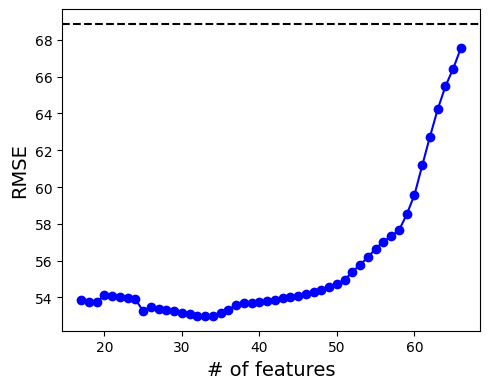

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))
ax1.plot(n_features, rfe_results["rmse_cv"], '-bo')
ax1.axhline(errors_gpr_cv_fpnorm['rmse_val'].mean(), linestyle='--', color='k')
#ax1.set_ylim(70,100)
ax1.set_xlabel('# of features', fontsize=14)
ax1.set_ylabel('RMSE', fontsize=14)
plt.tight_layout()

In [ ]:
print("Initial number of features", len(Xcols))
print("Selected number of features", len(sel_features))

Initial number of features 67
Selected number of features 33


In [ ]:
print("Mean square error with RFE (eV^2): ", rmse)

Mean square error with RFE (eV^2):  52.98498160555373


In [ ]:
X_new = new_data[sel_features]
X_new

,C.al,C.cu,C.ni,Dk_fr,Dk_fG,Dk_vec,Dk_Ec,Dk_w,Dk_fA,Dk_A,...,C.1,C.3,C.4,C.5,C.7,C.8,C.11,D.1,D.2,D.3
0,0.000000,0.000000,0.250000,-2.442590,-2.141950,0.756149,2.135291,1.345709,-2.030900,-2.584580,...,0.000000,0.000000,0.000000,0.000000,-0.735600,0.000000,0.000000,0.000000,0.686125,-0.821190
1,0.222222,0.222222,0.222222,0.575486,-0.083060,0.572989,-0.958400,-0.115690,0.286611,0.234105,...,0.218837,0.049013,0.215141,0.218837,-0.082933,0.218837,0.218837,0.218837,0.538307,0.209229
2,0.428571,0.071429,0.142857,1.093749,1.670192,-1.645860,-1.658190,-0.996000,0.880942,0.470273,...,0.405140,0.178058,0.381930,0.415263,0.855442,0.414343,0.415263,0.405140,-0.972153,-0.098731
3,0.090909,0.181818,0.181818,-0.319490,-0.341910,0.786121,0.084875,0.320048,-0.576900,-0.229710,...,0.090675,0.008254,0.090411,0.090351,-0.326621,0.090351,0.090351,0.090675,0.706767,0.974089
4,0.149925,0.000000,0.000000,0.241201,-0.289360,-0.935790,0.572974,-1.092060,0.404645,0.568023,...,0.148878,0.022402,0.147712,0.147663,-0.281224,0.149364,0.147663,0.148878,-0.802448,-0.977057
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.225000,0.000000,0.225000,0.698325,0.029721,-0.430730,0.535361,0.221653,0.850731,0.737584,...,0.221487,0.050236,0.217656,0.221487,0.029332,0.221487,0.221487,0.221487,-0.414504,0.147070
96,0.117647,0.000000,0.147059,0.014367,-0.705380,-0.737140,0.743195,-1.564280,0.072990,0.386799,...,0.117140,0.013813,0.116571,0.114266,-0.625169,0.117008,0.114266,0.117140,-0.670822,-0.786671
97,0.166667,0.083333,0.166667,0.320476,-0.000690,-0.013120,0.246484,0.220505,0.309614,0.421990,...,0.165230,0.027663,0.163637,0.165230,-0.000688,0.165230,0.165230,0.165230,-0.013067,0.987899
98,0.166667,0.000000,0.166667,0.353340,-0.050140,-0.892290,0.483511,-0.504690,0.593701,0.707933,...,0.165230,0.027663,0.163637,0.165230,-0.049234,0.165230,0.165230,0.165230,-0.775386,0.060009


In [ ]:
gaussian_process = GaussianProcessRegressor(
    kernel=k_opt, alpha=alpha_opt, n_restarts_optimizer=3
)

kf = KFold(n_splits=5)

errors = []
kernels = []

for idx, (train, val) in enumerate(kf.split(X)):
    X_cv_train = X.values[train]
    X_cv_val = X.values[val]

    y_cv_train = y.values[train]
    y_cv_val = y.values[val]


    # Model fit and prediction
    model = gaussian_process.fit(X_cv_train, y_cv_train)
    y_pred_val = model.predict(X_cv_val)
    y_pred_train = model.predict(X_cv_train)


    # Computing errors
    rmse_val = np.sqrt(mean_squared_error(y_cv_val, y_pred_val))
    mse_val = mean_squared_error(y_cv_val, y_pred_val)
    rmse_train = np.sqrt(mean_squared_error(y_cv_train, y_pred_train))

    r2_val = r2_score(y_cv_val, y_pred_val)
    r2_train = r2_score(y_cv_train, y_pred_train)


    # Plot Parity plot
    #polt_parity(y_cv_val,y_pred_val, y_cv_train,y_pred_train, label="Val")

    #print("Kernel parameters: %s"%(model.kernel_))
    #print("log marginal likelihood: %.3f" %model.log_marginal_likelihood_value_)
    #print("Root mean squared error: %.2f" % rmse_val)
    #print("Coefficient of determination: %.2f" % r2_val)

    error = {'kfold': idx+1,
             'rmse_train': rmse_train,
             'r2_train': r2_train,
             'rmse_val': rmse_val,
             'r2_val': r2_val,
             'mse_val': mse_val
            }

    errors.append(error)
    kernels.append(model.kernel_)

In [ ]:
errors_gpr_cv_opt_alpha = pd.DataFrame(errors)
errors_gpr_cv_opt_alpha.mean()

kfold            3.000000
rmse_train      21.616290
r2_train         0.986118
rmse_val        70.784238
r2_val           0.841172
mse_val       5282.015926
dtype: float64

In [ ]:
np.sqrt(errors_gpr_cv_opt_alpha['mse_val'].mean())

72.67747881032643

In [ ]:
# Again finding the best kernel parameters for final model training
sigma_cs = []
sigma_ls = []

print("Previous k_best: ", k_opt)

for k in kernels:
    sigma_cs.append(k.k1.constant_value)
    sigma_ls.append(k.k2.length_scale)
k_opt1 = np.median(sigma_cs) * RBF(length_scale=np.median(sigma_ls), length_scale_bounds=(1e-4, 1e2))
k_opt1.k1.constant_value_bounds = (10**-2, 10**7)

print("New k_best: ", k_opt1)

Previous k_best:  323**2 * RBF(length_scale=0.233)
New k_best:  321**2 * RBF(length_scale=3.9)


In [ ]:
# IMP NOTE: The optimizer is set to None

gaussian_process = GaussianProcessRegressor(kernel=k_opt1, alpha=alpha_opt, optimizer=None)

model = gaussian_process.fit(X,y)
print()
print(model.kernel_, model.kernel)


321**2 * RBF(length_scale=3.9) 321**2 * RBF(length_scale=3.9)


### Question:
7. What are the limitation(s) of the manner in which we carried out the RFE step.
9. Optimize alpha with the selected set of features to obtain hyper-parameters of the final GPR model.
9. Use the obtained hyper-parameters (from the above question) to train the final GPR model and make predictions for the test data. Plot test predictions and associated uncertainty.  

In [ ]:
### Downloading full test dataset file

In [ ]:
!gdown 16duLg9Z1l_zHmF8egJHe3JfultJQgJvG

Downloading...
From: https://drive.google.com/uc?id=16duLg9Z1l_zHmF8egJHe3JfultJQgJvG
To: /content/alloy-full-test-data_v2.csv
100% 8.41k/8.41k [00:00<00:00, 12.5MB/s]


In [ ]:
full_test_data = pd.read_csv('/content/drive/MyDrive/ML-Project-Group10/output10 new.csv')
full_test_data

,Unnamed: 0,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,...,sqrt_C.cu,exp_C.fe,exp_neg_C.fe,cubed_C.fe,squared_C.fe,sqrt_C.fe,exp_C.ni.1,exp_neg_C.ni,cubed_C.ni,squared_C.ni
0,0,4,127,0.090909,0.227273,0.227273,0.000000,0.227273,0.227273,-0.289290,...,0.000000,1.255172,0.796703,0.011739,0.051653,0.476731,1.255172,0.796703,0.011739,0.051653
1,1,18,158,0.000000,0.225000,0.100000,0.225000,0.225000,0.225000,-2.010640,...,0.474342,1.252323,0.798516,0.011391,0.050625,0.474342,1.252323,0.798516,0.011391,0.050625
2,2,36,205,0.142857,0.285714,0.000000,0.000000,0.285714,0.285714,0.204263,...,0.000000,1.330712,0.751477,0.023324,0.081633,0.534522,1.330712,0.751477,0.023324,0.081633
3,3,40,238,0.090909,0.000000,0.181818,0.181818,0.181818,0.363636,-0.302790,...,0.426401,1.199396,0.833753,0.006011,0.033058,0.426401,1.438551,0.695144,0.048084,0.132231
4,4,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.283273,...,0.408248,1.181360,0.846482,0.004630,0.027778,0.408248,1.181360,0.846482,0.004630,0.027778
5,5,48,295,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.230839,...,0.277350,1.166311,0.857404,0.003641,0.023669,0.392232,1.166311,0.857404,0.003641,0.023669
6,6,51,315,0.137931,0.000000,0.172414,0.172414,0.172414,0.344828,0.112354,...,0.415227,1.188169,0.841631,0.005125,0.029727,0.415227,1.411746,0.708342,0.041002,0.118906
7,7,55,358,0.166667,0.166667,0.166667,0.083333,0.166667,0.250000,0.329755,...,0.288675,1.181360,0.846482,0.004630,0.027778,0.408248,1.284025,0.778801,0.015625,0.062500
8,8,64,392,0.166667,0.000000,0.166667,0.166667,0.166667,0.333333,0.310678,...,0.408248,1.181360,0.846482,0.004630,0.027778,0.408248,1.395612,0.716531,0.037037,0.111111
9,9,68,423,0.181818,0.181818,0.181818,0.181818,0.181818,0.090909,0.371165,...,0.426401,1.199396,0.833753,0.006011,0.033058,0.426401,1.095169,0.913101,0.000751,0.008264


In [ ]:
new_data = full_test_data.copy()

In [ ]:
def make_new_feature(full_test_data, cols, powers, new_col_name):
    full_test_data[new_col_name] = 1
    for power, col  in zip(powers, cols):
        full_test_data[new_col_name] = np.cos(full_test_data[new_col_name]) * np.sin((full_test_data[Xcols[col]]) ** power)

    return full_test_data

def make_new_feature1(full_test_data, cols, powers, new_col_name):
    full_test_data[new_col_name] = 1
    for power, col  in zip(powers, cols):
        full_test_data[new_col_name] = full_test_data[new_col_name] * np.sin((full_test_data[Xcols[col]]) ** power)

    return full_test_data


In [ ]:

cols = [0,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.1')

cols = [1,3]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.2')

cols = [0,0]
powers = [1,2]
new_data = make_new_feature(new_data, cols, powers, 'C.3')

cols = [0,0,0]
powers = [1,1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.4')

cols = [4,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.5')

cols = [3,1]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.6')

cols = [9,8]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.7')

cols = [5,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.8')

cols = [0,16]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.9')

cols = [0,16]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.10')

cols = [4,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'C.11')

cols = [0,0]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'D.1')

cols = [0,11]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'D.2')

cols = [9,14]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'D.3')

cols = [11,21]
powers = [1,1]
new_data = make_new_feature(new_data, cols, powers, 'D.4')


In [ ]:
new_data

,Unnamed: 0,ID,HV,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,...,C.6,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4
0,0,4,127,0.090909,0.227273,0.227273,0.000000,0.227273,0.227273,-0.289290,...,0.225321,-0.816709,0.090112,-0.860100,-0.860100,0.090112,0.090675,0.126254,0.090413,-0.392477
1,1,18,158,0.000000,0.225000,0.100000,0.225000,0.225000,0.225000,-2.010640,...,0.221487,-0.978669,0.000000,-0.997619,-0.997619,0.000000,0.000000,0.931519,0.146396,-0.817474
2,2,36,205,0.142857,0.285714,0.000000,0.000000,0.285714,0.285714,0.204263,...,0.281843,-0.840842,0.140724,-0.986889,-0.986889,0.140724,0.141951,0.575133,-0.867896,0.092279
3,3,40,238,0.090909,0.000000,0.181818,0.181818,0.181818,0.363636,-0.302790,...,0.000000,-0.340804,0.089113,-0.268653,-0.268653,0.090351,0.090675,0.854149,-0.264257,-0.481560
4,4,42,249,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.283273,...,0.325881,-0.571430,0.165230,-0.475743,-0.475743,0.165230,0.165230,0.758715,0.056192,0.027533
5,5,48,295,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.230839,...,0.302599,-0.179093,0.152715,-0.106321,-0.106321,0.152715,0.152715,0.121413,0.921223,0.183783
6,6,51,315,0.137931,0.000000,0.172414,0.172414,0.172414,0.344828,0.112354,...,0.000000,0.039975,0.135207,0.168082,0.168082,0.136904,0.137115,0.606555,-0.020218,-0.054525
7,7,55,358,0.166667,0.166667,0.166667,0.083333,0.166667,0.250000,0.329755,...,0.165728,-0.004197,0.164416,0.117406,0.117406,0.165230,0.165230,0.096234,0.981160,0.309563
8,8,64,392,0.166667,0.000000,0.166667,0.166667,0.166667,0.333333,0.310678,...,0.000000,0.257112,0.163311,0.392600,0.392600,0.165230,0.165230,0.411991,0.059461,0.188474
9,9,68,423,0.181818,0.181818,0.181818,0.181818,0.181818,0.090909,0.371165,...,0.179956,0.477953,0.180601,0.603534,0.603534,0.179956,0.179956,-0.052802,0.988809,0.283602


In [ ]:
Xcols = new_data.columns[new_data.columns.str.contains("C.") | new_data.columns.str.contains("Dk_.") | new_data.columns.str.contains("C.")| new_data.columns.str.contains("D.")]
X = new_data[Xcols]
X   # 67 columns ###########################################################

,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,Dk_fG,Dk_fx,...,C.6,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4
0,0.090909,0.227273,0.227273,0.000000,0.227273,0.227273,-0.289290,1.180917,-0.977770,-0.328190,...,0.225321,-0.816709,0.090112,-0.860100,-0.860100,0.090112,0.090675,0.126254,0.090413,-0.392477
1,0.000000,0.225000,0.100000,0.225000,0.225000,0.225000,-2.010640,0.269944,-1.482200,-2.787710,...,0.221487,-0.978669,0.000000,-0.997619,-0.997619,0.000000,0.000000,0.931519,0.146396,-0.817474
2,0.142857,0.285714,0.000000,0.000000,0.285714,0.285714,0.204263,-0.331000,-1.302660,-1.242920,...,0.281843,-0.840842,0.140724,-0.986889,-0.986889,0.140724,0.141951,0.575133,-0.867896,0.092279
3,0.090909,0.000000,0.181818,0.181818,0.181818,0.363636,-0.302790,0.245639,-0.350480,-0.227420,...,0.000000,-0.340804,0.089113,-0.268653,-0.268653,0.090351,0.090675,0.854149,-0.264257,-0.481560
4,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.283273,-1.227010,-0.670300,-0.842130,...,0.325881,-0.571430,0.165230,-0.475743,-0.475743,0.165230,0.165230,0.758715,0.056192,0.027533
5,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.230839,0.005193,-0.180080,-0.023960,...,0.302599,-0.179093,0.152715,-0.106321,-0.106321,0.152715,0.152715,0.121413,0.921223,0.183783
6,0.137931,0.000000,0.172414,0.172414,0.172414,0.344828,0.112354,-0.094270,0.040244,0.211135,...,0.000000,0.039975,0.135207,0.168082,0.168082,0.136904,0.137115,0.606555,-0.020218,-0.054525
7,0.166667,0.166667,0.166667,0.083333,0.166667,0.250000,0.329755,-0.008690,-0.004240,0.267033,...,0.165728,-0.004197,0.164416,0.117406,0.117406,0.165230,0.165230,0.096234,0.981160,0.309563
8,0.166667,0.000000,0.166667,0.166667,0.166667,0.333333,0.310678,-0.301990,0.267318,0.442340,...,0.000000,0.257112,0.163311,0.392600,0.392600,0.165230,0.165230,0.411991,0.059461,0.188474
9,0.181818,0.181818,0.181818,0.181818,0.181818,0.090909,0.371165,-0.394290,0.504455,0.279998,...,0.179956,0.477953,0.180601,0.603534,0.603534,0.179956,0.179956,-0.052802,0.988809,0.283602


In [ ]:
X

,C.al,C.co,C.cr,C.cu,C.fe,C.ni,Dk_fr,Dk_G,Dk_fG,Dk_fx,...,C.6,C.7,C.8,C.9,C.10,C.11,D.1,D.2,D.3,D.4
0,0.090909,0.227273,0.227273,0.000000,0.227273,0.227273,-0.289290,1.180917,-0.977770,-0.328190,...,0.225321,-0.816709,0.090112,-0.860100,-0.860100,0.090112,0.090675,0.126254,0.090413,-0.392477
1,0.000000,0.225000,0.100000,0.225000,0.225000,0.225000,-2.010640,0.269944,-1.482200,-2.787710,...,0.221487,-0.978669,0.000000,-0.997619,-0.997619,0.000000,0.000000,0.931519,0.146396,-0.817474
2,0.142857,0.285714,0.000000,0.000000,0.285714,0.285714,0.204263,-0.331000,-1.302660,-1.242920,...,0.281843,-0.840842,0.140724,-0.986889,-0.986889,0.140724,0.141951,0.575133,-0.867896,0.092279
3,0.090909,0.000000,0.181818,0.181818,0.181818,0.363636,-0.302790,0.245639,-0.350480,-0.227420,...,0.000000,-0.340804,0.089113,-0.268653,-0.268653,0.090351,0.090675,0.854149,-0.264257,-0.481560
4,0.166667,0.333333,0.000000,0.166667,0.166667,0.166667,0.283273,-1.227010,-0.670300,-0.842130,...,0.325881,-0.571430,0.165230,-0.475743,-0.475743,0.165230,0.165230,0.758715,0.056192,0.027533
5,0.153846,0.307692,0.153846,0.076923,0.153846,0.153846,0.230839,0.005193,-0.180080,-0.023960,...,0.302599,-0.179093,0.152715,-0.106321,-0.106321,0.152715,0.152715,0.121413,0.921223,0.183783
6,0.137931,0.000000,0.172414,0.172414,0.172414,0.344828,0.112354,-0.094270,0.040244,0.211135,...,0.000000,0.039975,0.135207,0.168082,0.168082,0.136904,0.137115,0.606555,-0.020218,-0.054525
7,0.166667,0.166667,0.166667,0.083333,0.166667,0.250000,0.329755,-0.008690,-0.004240,0.267033,...,0.165728,-0.004197,0.164416,0.117406,0.117406,0.165230,0.165230,0.096234,0.981160,0.309563
8,0.166667,0.000000,0.166667,0.166667,0.166667,0.333333,0.310678,-0.301990,0.267318,0.442340,...,0.000000,0.257112,0.163311,0.392600,0.392600,0.165230,0.165230,0.411991,0.059461,0.188474
9,0.181818,0.181818,0.181818,0.181818,0.181818,0.090909,0.371165,-0.394290,0.504455,0.279998,...,0.179956,0.477953,0.180601,0.603534,0.603534,0.179956,0.179956,-0.052802,0.988809,0.283602


In [ ]:
y = new_data['HV']

In [ ]:
y

0     127
1     158
2     205
3     238
4     249
5     295
6     315
7     358
8     392
9     423
10    469
11    487
12    521
13    576
14    602
15    639
16    665
17    695
18    720
19    775
Name: HV, dtype: int64

In [ ]:
test_y_pred, test_y_std = model.predict(X, return_std=True)

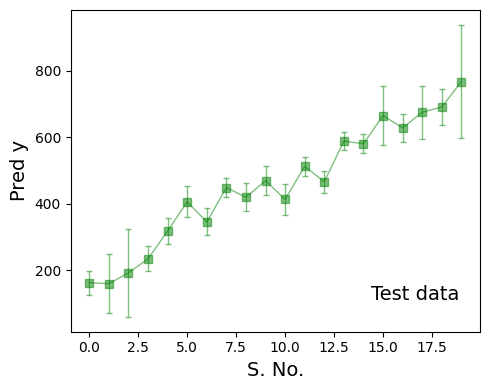

In [ ]:
fig, ax1 = plt.subplots(nrows=1, ncols=1, figsize=(5,4))


ax1.errorbar(np.arange(len(test_y_pred)), test_y_pred, test_y_std*1.5, fmt='-s', c='g', alpha=0.5, elinewidth=1, capsize=2, lw=1)
#ax1.plot([50,900], [50,900], '--k')

ax1.set_xlabel('S. No.', fontsize=14)
ax1.set_ylabel('Pred y', fontsize=14)

ax1.text(0.95, 0.1, "Test data", transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.18, "RMSE: %.2f"%rmse_train, transform=ax1.transAxes, ha='right', fontsize=14)
#ax1.text(0.95, 0.1, "R2: %.2f"%r2_train, transform=ax1.transAxes, ha='right', fontsize=14)

#ax1.set_xlim([50,900])
#ax1.set_ylim([50,900])

plt.tight_layout()
plt.show()

In [ ]:
# Visualisation
D1 = {'y_test': y, 'y_pred': test_y_pred, 'Error in Prediction': [a - b for a, b in zip(y, test_y_pred)]}

# Create the DataFrame
result = pd.DataFrame(D1)

# Display the DataFrame
print(result)

    y_test      y_pred  Error in Prediction
0      127  162.574056           -35.574056
1      158  159.423765            -1.423765
2      205  192.058132            12.941868
3      238  234.211829             3.788171
4      249  317.799999           -68.799999
5      295  405.867506          -110.867506
6      315  345.122833           -30.122833
7      358  448.711248           -90.711248
8      392  419.280153           -27.280153
9      423  469.690606           -46.690606
10     469  413.251166            55.748834
11     487  512.542137           -25.542137
12     521  466.031979            54.968021
13     576  588.178126           -12.178126
14     602  580.637256            21.362744
15     639  665.403460           -26.403460
16     665  628.385329            36.614671
17     695  675.267037            19.732963
18     720  691.125766            28.874234
19     775  767.675606             7.324394


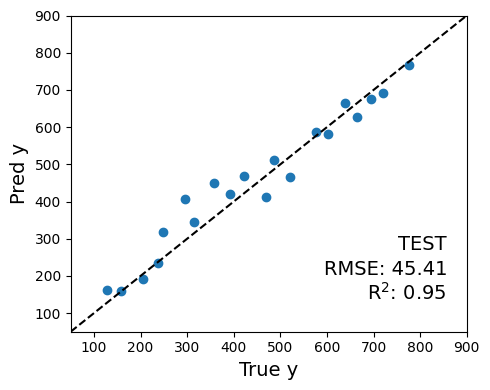

Kernel parameters: 321**2 * RBF(length_scale=3.9)
Root mean squared error: 45.41
Coefficient of determination: 0.95


In [ ]:
rmse_test = np.sqrt(mean_squared_error(y, test_y_pred))
r2_test = r2_score(y, test_y_pred)

# Plot Parity plot
polt_parity(y,test_y_pred,label="TEST")

print("Kernel parameters: %s"%(model.kernel_))
print("Root mean squared error: %.2f" % rmse_test)
print("Coefficient of determination: %.2f" % r2_test)
